## OPTICAL TWEEZERS

<b>IMPORTING REQUIRED MODULES</b>

In [1]:
%matplotlib notebook

import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt

import time
import sys
import glob

from multiprocessing import Process
import threading

import ipywidgets as widgets
from ipywidgets import Layout, interact, fixed

"""
Using IPython File Upload: 
https://github.com/peteut/ipython-file-upload
pip install fileupload
jupyter nbextension install --py fileupload
jupyter nbextension enable --py fileupload
"""
import io
from IPython.display import display
#import fileupload

from PyDAQmx import *
import ctypes
from ctypes import byref

import pickle
#################################################################################
#
# To get this working on a new machine you might need to:
#    * install the niDAQmx drivers from National Instruments
#    * install PyDAQmx ('pip install PyDAQmx' should do it)
#
#################################################################################

NotImplementedError: Location of niDAQmx library and include file unknown on win32 - if you find out, please let the PyDAQmx project know

In this code, we use the NI-DAQmx C Functions to interface with the NI board. This NI DAQ outputs signals and receives input from the Thorlabs cubes which are connected to the piezo stage (x,y,z) and the photodiode. 

You can see how the NI-DAQmx functions are used in the documentation below:

http://zone.ni.com/reference/en-XX/help/370471W-01/TOC3.htm

#### Initializing the DAQ parameters

In [2]:
#Setting up NI DAQ parameters
x_piezo = "Dev1/ao0" #The x-piezo is connected to AO0 (pin 12)
y_piezo = "Dev1/ao1" #The y-piezo is connected to AO1 (pin 13)
inChannels = "Dev1/ai0, Dev1/ai1, Dev1/ai2, Dev1/ai3"
num_input_channels = 4


#autoStart is a boolean (true or false) controlling when DAQ output is sent
autoStart = 0

dataLayout = DAQmx_Val_GroupByChannel
fillMode = DAQmx_Val_GroupByChannel
timeout = 10
read = int32()
sampsWritten = int32()
'''
#Ways to structure data 



inputData = np.zeros((num_samps*num_input_channels,),dtype=np.float64)
sampsWritten = int32()

'''

def setUpOutput(device, num_samps=20000, sampling_rate=1000, tsk=None, timing=True):
    '''
    Initialize the DAQ for sending analog outputs
    For waveforms, use timing=True
    For sending a single voltage, use timing=False
    Device is "Dev1/ao0", "Dev1/ao1", or whatever the right channel is
    '''
    if tsk is None:
        tsk = Task()
    tsk.CreateAOVoltageChan(device,"",0.0,10.0,DAQmx_Val_Volts,None) #sets up channel for output between 0 and 10 V
    if timing:
        tsk.CfgSampClkTiming("", sampling_rate, DAQmx_Val_Rising, DAQmx_Val_FiniteSamps, num_samps)
    return tsk

def setUpInput(tsk=None, sampling_rate=1000, num_samps=20000):
    if tsk is None:
        tsk = Task()
    tsk.CreateAIVoltageChan(inChannels, "", DAQmx_Val_Cfg_Default,-10.0,10.0,DAQmx_Val_Volts,None)
    tsk.CfgSampClkTiming("",sampling_rate,DAQmx_Val_Rising,DAQmx_Val_FiniteSamps, num_samps)
    return tsk

<b>Setting piezo values.</b>

With the chunk of code below, you'll be able to set the piezo stages to a certain position. 

In [3]:
###################################################################
# This first section of code sets up the graphical user interface #
###################################################################
axes_buttons = widgets.ToggleButtons(options=['x-axis','y-axis'],
                                    description='Piezo Axis',
                                    disabled=False)
display(axes_buttons)

singlevalue_text = widgets.BoundedFloatText(description="Set Voltage", 
                                            value=2.5, min=0.0,max=10.0,step=0.1)
display(singlevalue_text)

run_singleV_button = widgets.Button(description="Run Voltage Output!",
                                   tooltip="Send specified voltage to selected piezo")
display(run_singleV_button)

###################################################################
#       End of graphical user interface setup                     #
###################################################################

def on_valbutton(b):
    if axes_buttons.value == 'x-axis':
        axis = x_piezo
    elif axes_buttons.value == 'y-axis':
        axis = y_piezo
    to = setUpOutput(axis, timing=False) #Use "timing=False" for sending a single voltage to piezo
    voltage = singlevalue_text.value #read's the inputted voltage from textbox
    to.WriteAnalogScalarF64(1, 10.0, voltage, None)
    time.sleep(0.5)
    to.StopTask()


run_singleV_button.on_click(on_valbutton)

ToggleButtons(description='Piezo Axis', options=('x-axis', 'y-axis'), value='x-axis')

BoundedFloatText(value=2.5, description='Set Voltage', max=10.0, step=0.1)

Button(description='Run Voltage Output!', style=ButtonStyle(), tooltip='Send specified voltage to selected pie…

<b>Oscillation Experiments</b>

In [7]:
###################################################################
# This first section of code sets up the graphical user interface #
###################################################################
axes_buttons = widgets.ToggleButtons(options=['x-axis','y-axis'],
                                    description='Piezo Axis..........................',
                                    disabled=False)
display(axes_buttons)

sampfreq_text = widgets.BoundedFloatText(description="Sampling Frequency", value=1000, min=100,max=200000,step=100,
                                   tooltip="Sampling Frequency in Hz")
display(sampfreq_text)

amp_text = widgets.BoundedFloatText(description="Amplitude", value=0.5, min=0.0,max=10.0,step=0.1,
                                   tooltip="Amplitude of Oscillation in Volts")
display(amp_text)

offset_text = widgets.BoundedFloatText(description="Offset", value=2.5, min=0.1,max=9.9,step=0.1,
                                   tooltip="Offset of Oscillation in Volts")
display(offset_text)

rb = widgets.RadioButtons(options=['Sine','Square','Sawtooth'],description='Waveform',disabled=False)
display(rb)

freq_text = widgets.BoundedFloatText(description="Oscillation Frequency", value=2, min=0.1,max=40.0,step=0.1,
                                   tooltip="Frequency of Oscillation in Hz")
display(freq_text)

numosc_text = widgets.BoundedFloatText(description="Number of Oscillations", value=4, min=1,max=10,step=0.1,
                                   tooltip="How many cycles to run")
display(numosc_text)

run_osc_button = widgets.Button(description="Run Oscillations!")
display(run_osc_button)

###################################################################
#       End of graphical user interface setup                     #
###################################################################

saved_data = {} #Initialize empty dictionary to store data

def on_oscbutton(b):
    
    #Check which axis to oscillate
    if axes_buttons.value == 'x-axis':
        print("x")
        axis = x_piezo
    elif axes_buttons.value == 'y-axis':
        print("y")
        axis = y_piezo
        
        
    num_osc = numosc_text.value #number of oscillations (from textbox)
    fs = sampfreq_text.value #sampling frequency
    freq = freq_text.value #frequency of oscillation 
    time_oscillating = num_osc / freq #time spend oscillating
    samples_oscillating = time_oscillating * fs #number of samples
    osc_freq_in_samples = freq / fs #oscillation frequency in units of samples rather than Hz
    
    #This will be the argument of the sine or sawtooth or square wave function
    sine_argument = 2*np.pi*osc_freq_in_samples*np.arange(samples_oscillating)
    
    amplitude = amp_text.value #Amplitude of oscillation
    offset = offset_text.value #Offset
    waveform = rb.value #kind of waveform, Sine, Square or Sawtooth
    
    if waveform=='Square':
        data = amplitude * scipy.signal.square(sine_argument) + offset
    elif waveform=='Sawtooth':
        data = amplitude * scipy.signal.sawtooth(sine_argument, width = 0.5) + offset
    elif waveform=='Sine':
        data = amplitude * np.sin(sine_argument) + offset
    else:
        data = np.ones_like(sine_argument)*offset
        
    half_second_of_const = np.ones((int(0.5*fs),),dtype=np.float64)*offset #half-second pause before oscillations begin
    dataOut = np.hstack((half_second_of_const, data)) #Data to send to piezo
    
    inputData = np.zeros((len(dataOut)*num_input_channels,),dtype=np.float64) #Data to recieve from NI DAQ board
    
    to = setUpOutput(axis, num_samps=len(dataOut), sampling_rate=fs, timing=True) #Output task
    ti = setUpInput(sampling_rate=fs, num_samps=len(dataOut)) #Input task
    
    ti.StartTask()
    to.WriteAnalogF64(len(dataOut),autoStart,timeout,dataLayout,dataOut,byref(sampsWritten),None)
    
    #Define processes that will start the input and output of the NI DAQ
    def outputProc():
        to.StartTask()
    def inputProc():
        ti.ReadAnalogF64(len(dataOut),timeout*2,fillMode,inputData,len(inputData),byref(read),None)
          
    #Make a list of threads. One thread is for input, the other output
    thread_list = []
    thread_list.append(threading.Thread(target=outputProc))
    thread_list.append(threading.Thread(target=inputProc))
    
    
    for thread in thread_list:
        thread.start()
        
    time.sleep(time_oscillating + 0.5)
    time.sleep(1.0)
    to.StopTask()
    ti.StopTask()
    
    #Store the data in the dictionary "saved_data"
    saved_data['Fs'] = fs
    saved_data['axis'] = axes_buttons.value
    saved_data['dataOut'] = dataOut
    saved_data['inputData_0'] = inputData[0:len(dataOut)]
    saved_data['inputData_1'] = inputData[len(dataOut):2*len(dataOut)]
    saved_data['inputData_2'] = inputData[2*len(dataOut):3*len(dataOut)]
    saved_data['inputData_3'] = inputData[3*len(dataOut):4*len(dataOut)]

    
run_osc_button.on_click(on_oscbutton)


ToggleButtons(description='Piezo Axis..........................', options=('x-axis', 'y-axis'), value='x-axis'…

BoundedFloatText(value=1000.0, description='Sampling Frequency', max=200000.0, min=100.0, step=100.0)

BoundedFloatText(value=0.5, description='Amplitude', max=10.0, step=0.1)

BoundedFloatText(value=2.5, description='Offset', max=9.9, min=0.1, step=0.1)

RadioButtons(description='Waveform', options=('Sine', 'Square', 'Sawtooth'), value='Sine')

BoundedFloatText(value=2.0, description='Oscillation Frequency', max=40.0, min=0.1, step=0.1)

BoundedFloatText(value=4.0, description='Number of Oscillations', max=10.0, min=1.0, step=0.1)

Button(description='Run Oscillations!', style=ButtonStyle())

x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x
x


In [102]:
print( "Keys in 'saved_data': ", saved_data.keys())
print("Length of inputData: ", len(saved_data['inputData_0']))

Keys in 'saved_data':  dict_keys(['Fs', 'axis', 'dataOut', 'inputData_0', 'inputData_1', 'inputData_2', 'inputData_3'])
Length of inputData:  4167


<IPython.core.display.Javascript object>


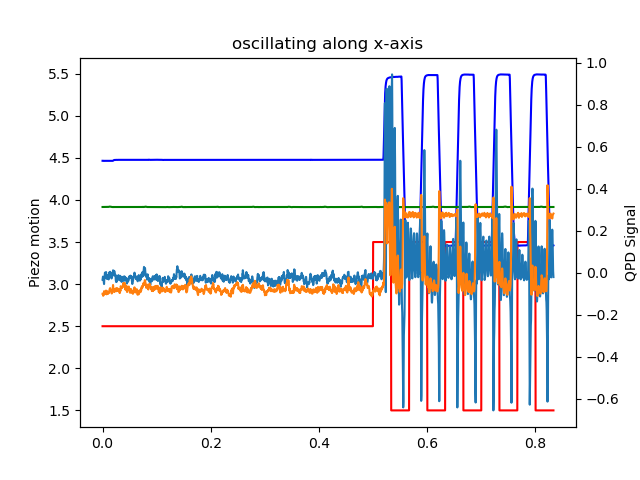

Text(0.5, 1.0, 'oscillating along x-axis')

In [103]:
#Because plotting a lot of data points on the same graph will either cause an error or slow down the program
#we only plot at most 2000 data points. Using 'np.linspace' to get the 2000 or fewer points
plt_points = np.linspace(0,len(saved_data['dataOut'])-1,min(2000,len(saved_data['dataOut'])),dtype=int)

#Convert to time
data_time = np.arange(0,len(saved_data['dataOut']))/saved_data['Fs']

fig,ax1 = plt.subplots() #Setup plot
ax1.plot(data_time[plt_points], saved_data['dataOut'][plt_points], 'r') #Signal sent to piezo
ax1.plot(data_time[plt_points], saved_data['inputData_2'][plt_points], 'b') #what piezo got (note time lag)
ax1.plot(data_time[plt_points], saved_data['inputData_3'][plt_points], 'g') #what other piezo axis got
ax1.set_ylabel("Piezo motion")

ax2 = ax1.twinx() #Now set up a new y-axis to plot the QPD signal
ax2.plot(data_time[plt_points], saved_data['inputData_0'][plt_points]-np.mean(saved_data['inputData_0'][plt_points]))
ax2.plot(data_time[plt_points], saved_data['inputData_1'][plt_points]-np.mean(saved_data['inputData_1'][plt_points]))
ax2.set_ylabel("QPD Signal")
ax2.patch.set_alpha(0.0)
plt.title("oscillating along " + saved_data['axis'])

In [101]:
## Here we save the data to a 'pickle' file
pickle.dump(saved_data, open("Oscillations_Sine_95ma_0820_15Hz.p",'wb'))

In [ ]:
ti.StopTask()

#### Acquiring data for power spectrum calibration method

In [ ]:
###################################################################
# This first section of code sets up the graphical user interface #
###################################################################
sampfreq_text = widgets.BoundedFloatText(description="Sampling Frequency", 
                                         value=100000, min=100,max=200000,step=100,
                                         tooltip="Sampling Frequency in Hz")
display(sampfreq_text)

numdata_text = widgets.BoundedIntText(description="Number of Datapoints", 
                                      value=100000, min=10000,max=1000000,step=10000,
                                      tooltip="How many datapoints to collect")
display(numdata_text)

run_ps_button = widgets.Button(description="Acquire Power Spectrum!")
display(run_ps_button)

###################################################################
#       End of graphical user interface setup                     #
###################################################################

saved_data_ps = {}

def on_runbutton(b):

    num_pts = numdata_text.value
    fs = sampfreq_text.value
    
    inputData = np.zeros((num_pts*num_input_channels,),dtype=np.float64)

    ti = setUpInput(sampling_rate=fs, num_samps=num_pts)
    ti.StartTask()
    ti.ReadAnalogF64(num_pts,timeout*2,fillMode,inputData,len(inputData),byref(read),None)
    time.sleep(num_pts/fs + 0.5)

    ti.StopTask()
    
    saved_data_ps['Fs'] = fs
    saved_data_ps['inputData_0'] = inputData[0:num_pts]
    saved_data_ps['inputData_1'] = inputData[num_pts:2*num_pts]
    saved_data_ps['inputData_2'] = inputData[2*num_pts:3*num_pts]
    saved_data_ps['inputData_3'] = inputData[3*num_pts:4*num_pts]

    
run_ps_button.on_click(on_runbutton)

In [ ]:
plt_points = np.linspace(0,len(saved_data_ps['inputData_0'])-1,min(2000,len(saved_data_ps['inputData_0'])),dtype=np.int)
data_time = np.arange(0,len(saved_data_ps['inputData_0']))/saved_data_ps['Fs']
fig,ax1 = plt.subplots()
ax1.plot(data_time[plt_points], saved_data_ps['inputData_0'][plt_points])
ax1.plot(data_time[plt_points], saved_data_ps['inputData_1'][plt_points])
ax1.set_ylabel("QPD Signal")

time_step = 1./saved_data_ps['Fs']
ps_0 = np.abs(np.fft.fft(saved_data_ps['inputData_0']))**2 * time_step
ps_1 = np.abs(np.fft.fft(saved_data_ps['inputData_1']))**2 * time_step
freqs = np.fft.fftfreq(len(saved_data_ps['inputData_0']), time_step)
idx = np.argsort(freqs)
fig2,ax2 = plt.subplots()
ax2.loglog(freqs[idx][plt_points], ps_0[idx][plt_points])
ax2.loglog(freqs[idx][plt_points], ps_1[idx][plt_points])

fig3,ax3 = plt.subplots()
ax3.loglog(freqs[idx][plt_points], ps_0[idx][plt_points]/freqs[idx][plt_points])
ax3.loglog(freqs[idx][plt_points], ps_1[idx][plt_points]/freqs[idx][plt_points])

binning = np.geomspace(1,1000000,num=1024,endpoint=False,dtype=np.int)
freqs_new = []; ps_0_new = []; ps_1_new = []
freqs_used = freqs[idx][len(freqs)/2:]
ps_0_used = ps_0[idx][len(freqs)/2:]
ps_1_used = ps_1[idx][len(freqs)/2:]
j=0
for i,space in enumerate(binning):
    if j<len(freqs_used):
        freqs_new.append(freqs_used[j:j+space].mean())
        ps_0_new.append(ps_0_used[j:j+space].mean())
        ps_1_new.append(ps_1_used[j:j+space].mean())
        j=j+space
    else:
        break

freqs_new = np.array(freqs_new); ps_0_new = np.array(ps_0_new); ps_1_new = np.array(ps_1_new)
fig4,ax4 = plt.subplots()
ax4.loglog(freqs_new, ps_0_new)
ax4.loglog(freqs_new, ps_1_new)

In [ ]:
pickle.dump(saved_data_ps, open("ps_90ma_0813.p",'w'))